In [197]:
#Unitary circuit of long range CNOT gate with and without dynamic decoupling, withouty DD is better
#because there exists no such error like idling error, therefore no need od DD

In [36]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
       
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

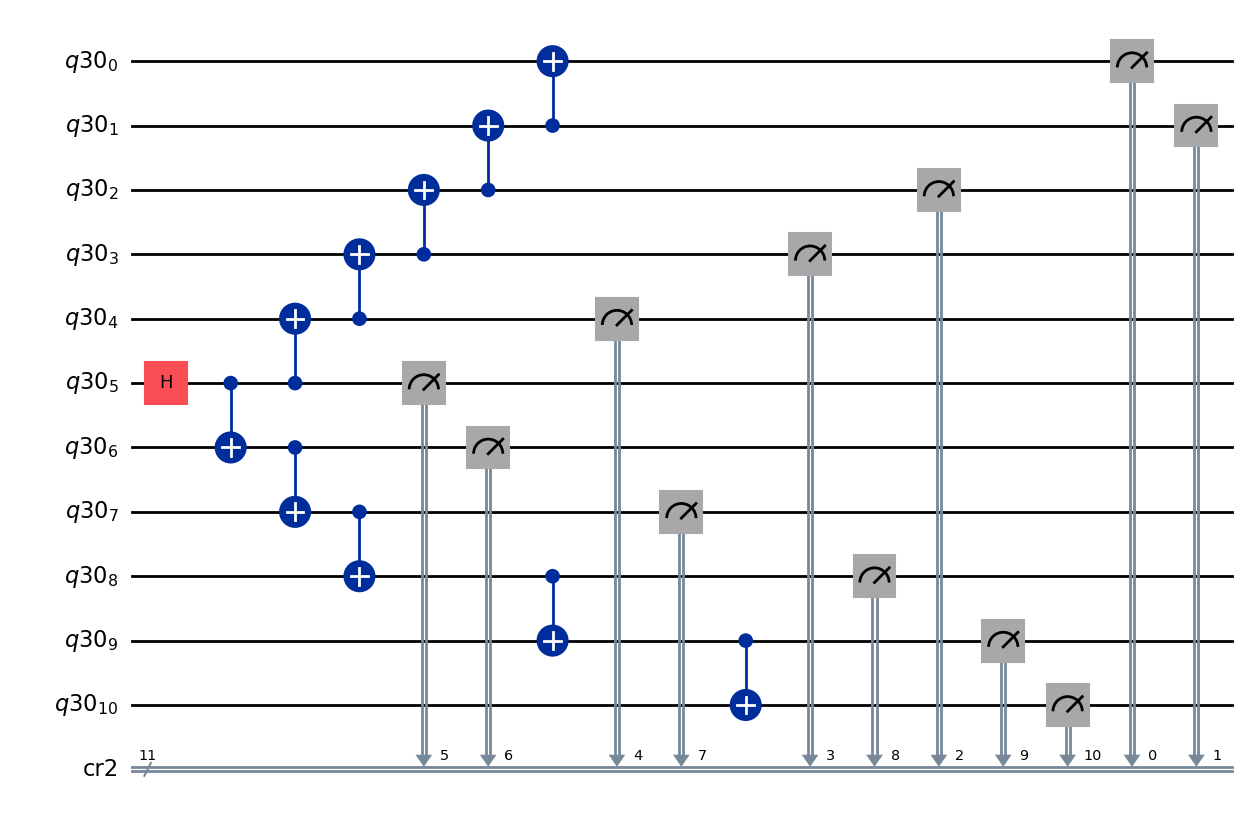

In [20]:
qc = get_ghz_circ_static(num_qubit=11)
qc.draw('mpl')

In [37]:
#Creating list of circuits [Static1, Dynamic1, Static1, Dyanmic1,...,static2,dynamic2,staic2,dynamic2,...] i.e. some copies of each of them
min_qubit=3
max_num_qubit=8
copies=2
#qc_list_dynamic=[]
#qc_list_static=[]
#observables=[]
qc_list=[]
num_qubit_list=[]
for i in range(min_qubit,max_num_qubit+1):
    num_qubit_list.append(i)

for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))
        qc_list.append(get_ghz_circ_static(num_qubit))
print(num_qubit_list)

[3, 4, 5, 6, 7, 8]


In [38]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
qc_transpiled_list=[]



qc_transpiled_list_ideal = pm.run(qc_list)
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [39]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_dd = result_ideal[(2*i*copies)+(2*j)].data         # static, dynamic both present , So iteration no of iteration indices are doubled                  
        data_static_without_dd = result_ideal[(2*i*copies)+((2*j)+1)].data
        counts_static_dd=data_static_dd.cr2.get_counts()
        counts_static_without_dd=data_static_without_dd.cr2.get_counts()
        counts_list_ideal.append(counts_static_dd)
        counts_list_ideal.append(counts_static_without_dd)

In [40]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
 
target = backend.target
basis_gates = list(target.operation_names)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(3, target=target, seed_transpiler=12345)
qc_t = pm.run(qc_list)
qc_t[0].draw("mpl", fold=-1, idle_wires=False)
print(basis_gates)

['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'for_loop', 'switch_case', 'if_else', 'delay']


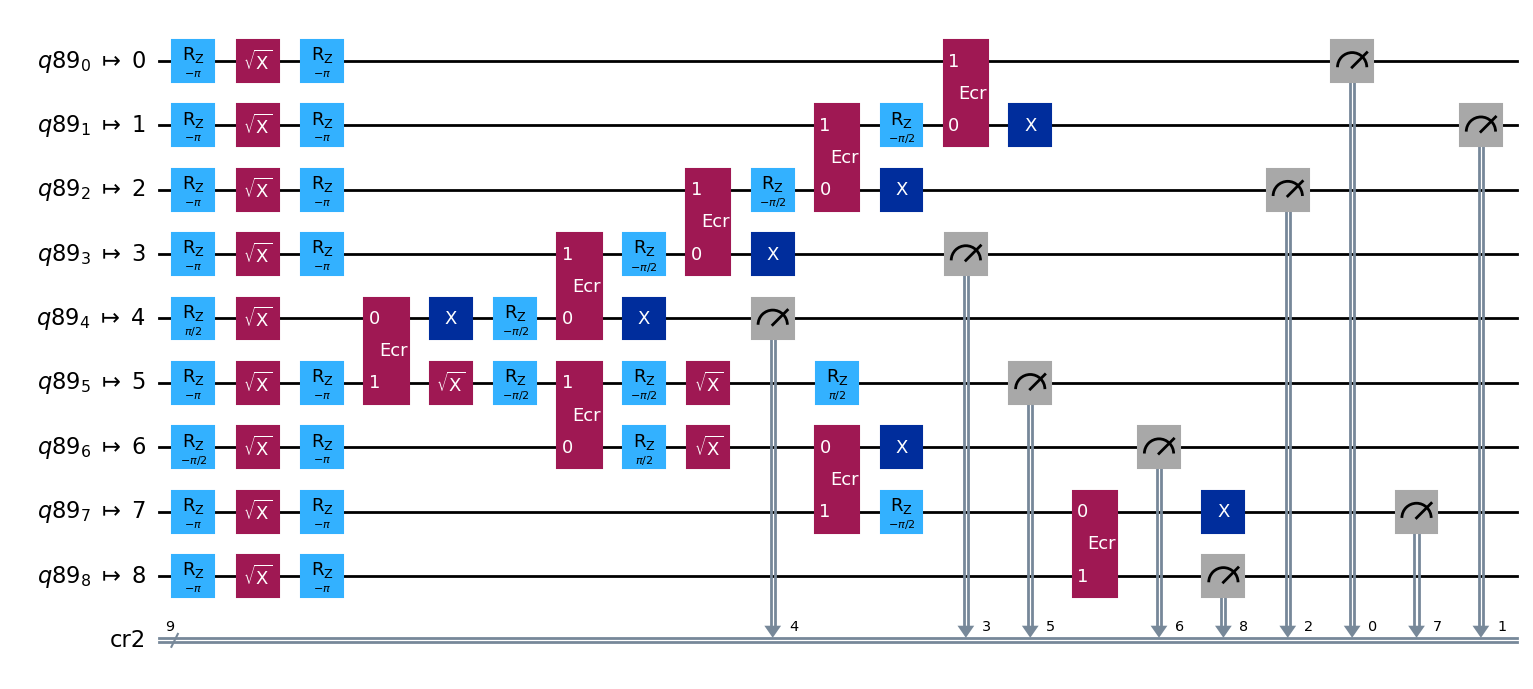

In [14]:
qc_t[0].draw("mpl", fold=-1, idle_wires=False)

In [41]:
from qiskit.circuit.library import XGate, YGate
 
X = XGate()
Y = YGate()
 
dd_sequence = [X, Y, X, Y]

In [42]:
from qiskit.transpiler import InstructionProperties
 
y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )
 
target.add_instruction(YGate(), y_gate_properties)

In [43]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
 
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)
qc_dd=[]
for i in range(2*copies*(max_num_qubit-min_qubit+1)):
    if i%2==0:
        qc_dd.append(dd_pm.run(qc_t[i]))
    else:
        qc_dd.append(qc_t[i])
  

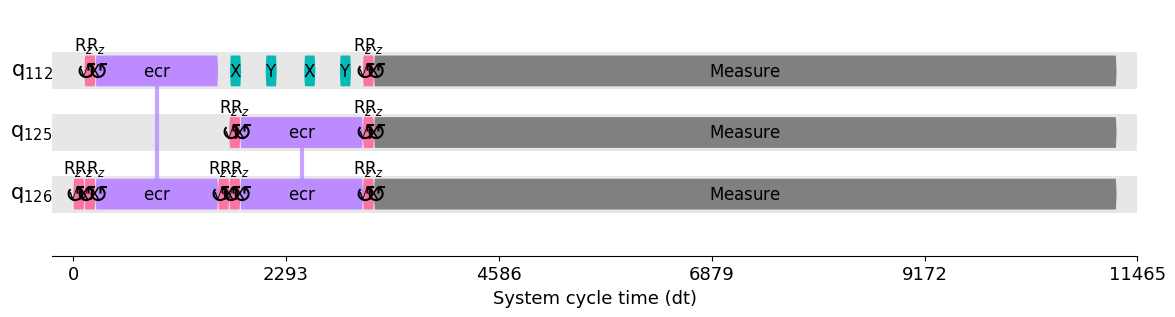

In [50]:
from qiskit.visualization import timeline_drawer
 
timeline_drawer(qc_dd[0], show_idle=False)

In [44]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
service = QiskitRuntimeService()
aer = AerSimulator.from_backend(backend)
pm = generate_preset_pass_manager(backend=aer, optimization_level=3)
isa_qc = pm.run(qc_dd)
sampler = Sampler(backend=aer)
result_brisbane = sampler.run(isa_qc).result()

In [45]:
counts_list_brisbane=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_dd = result_brisbane[(2*i*copies)+(2*j)].data
        data_static_without_dd = result_brisbane[(2*i*copies)+((2*j)+1)].data
        counts_static_dd=data_static_dd.cr2.get_counts()
        counts_static_without_dd=data_static_without_dd.cr2.get_counts()
        counts_list_brisbane.append(counts_static_dd)
        counts_list_brisbane.append(counts_static_without_dd)

In [46]:
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
# For GHZ state analysis: index 0 of these lists store informationn of GHZ state having 3 qubits, index 1 for 4 qubits and so on 
Fidelity_mean_static_brisbane=[]
Fidelity_mean_dynamic_brisbane=[]
Fidelity_std_static_brisbane=[]
Fidelity_std_dynamic_brisbane=[]
Fidelity_copies_static_brisbane=[]
Fidelity_copies_dynamic_brisbane=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_brisbane[(2*i*copies)+(2*j)])
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_brisbane[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_brisbane.append(Fidelity_static)
        Fidelity_copies_dynamic_brisbane.append(Fidelity_dynamic)

        
    
    Fidelity_mean_static_brisbane.append(statistics.mean(Fidelity_copies_static_brisbane))
    Fidelity_mean_dynamic_brisbane.append(statistics.mean(Fidelity_copies_dynamic_brisbane))
    Fidelity_std_static_brisbane.append(statistics.stdev(Fidelity_copies_static_brisbane))
    Fidelity_std_dynamic_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_brisbane))
    Fidelity_copies_static_brisbane.clear()
    Fidelity_copies_dynamic_brisbane.clear()

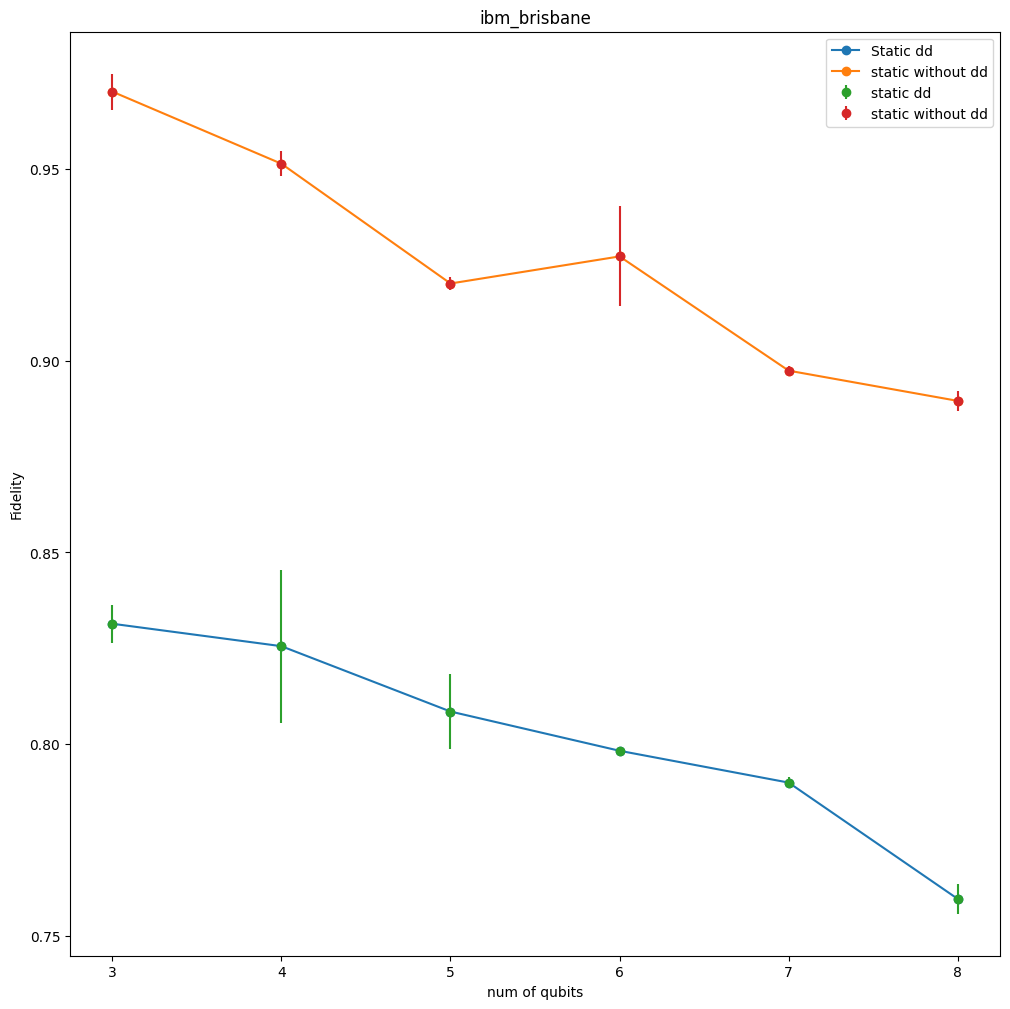

In [47]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
# Create  data.

ax.set_xlabel('num of qubits')
ax.set_ylabel('Fidelity')
ax.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static = Fidelity_mean_static_brisbane
y1_dynamic = Fidelity_mean_dynamic_brisbane
y_error_static =Fidelity_std_static_brisbane
y_error_dynamic =Fidelity_std_dynamic_brisbane
ax.plot(x1, y1_static, 'o-',label='Static dd')
ax.plot(x1, y1_dynamic, 'o-',label='static without dd')
ax.errorbar(x1, y1_static,
			yerr = y_error_static, label='static dd',
			fmt ='o')
ax.errorbar(x1, y1_dynamic,
			yerr = y_error_dynamic, label='static without dd',
			fmt ='o')



plt.legend()
plt.show()